In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [3]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [4]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return torch.sum(out,dim=3)


In [6]:
class Sin_func:
    def __init__(self, x, range=[-1,1], size=(1, 1), sample_size=1000, device="cuda"):
        self.x = x
        self.range = range
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        amp = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        freq = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        phase = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        
        params = torch.stack((amp, freq, phase))
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y =  params[:,0,0,0] * torch.sin(2 * torch.pi * params[:,0,1,0] * x + params[:,0,2,0])
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)  
        out[:, :, 0, 0] = torch.transpose(y, 0, 1)
        return torch.sum(out, dim=3)

In [7]:
sample_size = 10000
sequence_length = 1000
batch_size = 50
data_range = [-1, 1]
num_funcs = 4

x_values = torch.linspace(data_range[0], data_range[1], sequence_length)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full = linear.generate()

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full = quad.generate()

cube = Polynomial_func(x=x_values, range=data_range, degree=3, sample_size=sample_size, device=device)
cube_full = cube.generate()

sin = Sin_func(x=x_values, range=data_range, sample_size=sample_size, device=device)
sin_full = sin.generate()

all_data = DataLoader(torch.vstack([cube_full, quad_full, lin_full, sin_full]), batch_size=batch_size, shuffle=True)

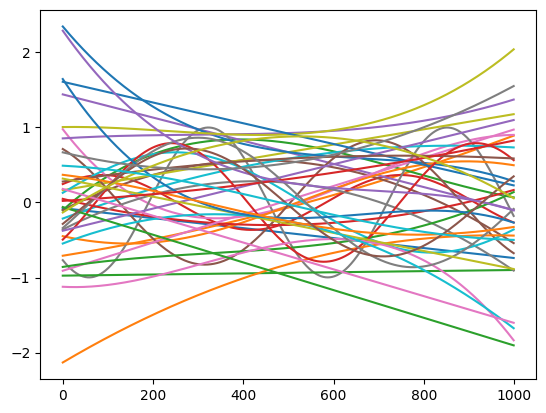

In [8]:
for i in range(10):
    r = np.random.randint(sample_size)
    plt.plot(lin_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quad_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(cube_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(sin_full[r, :, 0].detach().cpu().numpy(), "-")

In [9]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)
    
def sin_function(params, x, device):
    x = x.to(device)
    if params.size(1) == 3:
        amplitude = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        frequency = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        phase = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return amplitude * torch.sin(2 * torch.pi * frequency * x + phase)
    else:
        return torch.zeros_like(x)

In [10]:
def new_loss(output, target, x):
    target_range = torch.max(target, dim=-1, keepdim=True)[0] - torch.min(target, dim=-1, keepdim=True)[0]
    target_range = torch.clamp(target_range, min=1e-6).squeeze(-1)
    x = x.clone().detach().requires_grad_(True)
    target = target.clone().detach().requires_grad_(True)
    derivative_true = torch.autograd.grad(outputs=target, inputs=x, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_true is None:
        derivative_true = torch.zeros_like(output)
    derivative_pred = (torch.roll(output, shifts=-1, dims=1) - torch.roll(output, shifts=1, dims=1)) / (2 * 1e-8)
    mse_function = torch.mean(torch.abs(target - output)**4, dim=1)/target_range
    mse_derivative = torch.mean(torch.abs(derivative_pred - derivative_true)**4, dim=1)/target_range
    return mse_function + mse_derivative

In [61]:
class Encoder(nn.Module):
    def __init__(self, 
                 x_data,
                 functions,
                 device="cuda",
                 sequence_length=96, 
                 input_channel=2, 
                 cov1d_size=128,
                 drop_out=0.1):
        super(Encoder, self).__init__()
        self.x_data = x_data
        self.functions = functions
        self.device = device
        self.num_params = sum(self.functions[1])
        
        self.cov1d = nn.Conv1d(input_channel, cov1d_size, 3, stride=1, padding=1, padding_mode='zeros')
        self.flattened_size = cov1d_size * sequence_length
        self.dense = nn.Linear(self.flattened_size, self.num_params)
        
        self.relu_1 = nn.ReLU()

    def forward(self, x):
        targets = x.squeeze(dim=1)
        #print(f"initial x: {x.shape}")
        out = self.cov1d(x)
        #print(f"after cov1d: {out.shape}")        
        out = out.reshape(out.size(0), -1)
        #print(f"after flatten: {out.shape}")
        out = self.dense(out)
        #print(f"after dense: {out.shape}")
        out = self.relu_1(out)

        #loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        
        for f in range(len(self.functions[0])):
            #print(f"parameters: {out[:, start_index:start_index+self.functions[1][f]].shape}")
            #print(f"function: {self.functions[0][f]}")
            output = self.functions[0][f](
                out[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(device)
            #print(f"output: {output.shape}")
            outputs.append(output)
            #print(f"targets: {targets.shape}")
            loss = new_loss(output, targets, x)
            #print(f"loss: {loss[5]}")
            losses.append(loss)
            start_index += self.functions[1][f]        
        
        '''best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[0][best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]'''

        #print(f"outputs list: {outputs[0].shape}")
        #print(f"losses list: {losses[0].shape}")
        stacked_outputs = torch.stack(outputs)
        stacked_losses = torch.stack(losses)
        print(f"stacked_losses: {stacked_losses.shape}")
        print(f"linear all: {stacked_losses[0]}")
        print(f"quadratic all: {stacked_losses[1]}")
        print(f"cubic all: {stacked_losses[2]}")
        print(f"sin all: {stacked_losses[3]}")
        print(f"linear: {stacked_losses[0, 5]}")
        print(f"quadratic: {stacked_losses[1, 5]}")
        print(f"cubic: {stacked_losses[2, 5]}")
        print(f"sin: {stacked_losses[3, 5]}")
        #print(f"outputs: {outputs.shape}")
        #print(f"losses: {losses.shape}")
        best_loss, best_indexes = torch.min(stacked_losses, dim=0) 
        print(f"best_loss: {best_loss[5]}")
        print(f"best_indexes: {best_indexes[5]}")
        best_out = stacked_outputs[best_indexes, -1]
        #print(f"best_out: {best_out.shape}")
        best_func = [self.functions[0][idx] for idx in best_indexes]
        #print(f"best_func: {len(best_func)}")

        return best_out, best_loss, best_func, stacked_outputs, stacked_losses

In [62]:
functions = [[linear_function, quadratic_function, cubic_function, sin_function], [2,3,4,3]]
model = Encoder(x_data=x_values, functions=functions, device=device, sequence_length=sequence_length, input_channel=1, cov1d_size=128).to(device)

In [63]:
for train_batch in all_data:
    train_batch = torch.swapaxes(train_batch, 1, 2).to(device)
    best_out, best_loss, best_func, stacked_outputs, stack_losses = model(train_batch)
    print(f"best_loss: {best_loss[5]}")
    print(f"stacked_losses: {stack_losses[:, 5]}")
    print(f"best_func: {best_func[5]}")
    break


stacked_losses: torch.Size([4, 50])
linear all: tensor([8.0916e-02, 5.9662e-03, 1.8832e-01, 3.4657e+00, 3.0199e-01, 1.0245e+00,
        4.6030e+00, 3.4244e-01, 1.9511e+00, 6.0025e-03, 9.8599e-02, 3.0270e-01,
        1.1989e-02, 5.9837e+00, 7.6455e+00, 3.3157e-01, 9.3673e-03, 2.0524e+00,
        9.4247e-02, 3.0086e-01, 6.0571e+00, 1.0245e-01, 1.0133e-01, 1.3205e-01,
        1.7415e-02, 5.8204e-01, 1.0863e-03, 4.0299e+00, 7.6552e+00, 3.3534e-01,
        5.7383e-03, 9.2498e-02, 4.3196e-04, 2.7736e-01, 1.1318e-02, 1.6575e-01,
        2.5297e-04, 2.1860e-02, 1.2379e-01, 2.7512e+00, 7.2423e-01, 4.7329e-02,
        5.7116e-02, 1.8427e-01, 1.7824e-01, 6.6095e+00, 4.4740e-01, 4.2384e-02,
        2.9671e-01, 7.1985e-01], device='cuda:4', grad_fn=<SelectBackward0>)
quadratic all: tensor([1.9033e+28, 3.8438e+27, 6.9109e+27, 9.1535e+29, 8.3641e+25, 8.9402e+23,
        6.0651e-01, 6.2474e+25, 1.2750e+00, 8.3446e+27, 1.4144e+27, 5.6030e+25,
        3.3475e+27, 8.0134e-01, 1.0374e+00, 4.4898e+27, 7.35

In [14]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
epochs = 5
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    
    for train_batch in all_data:
        train_batch = torch.swapaxes(train_batch, 1, 2).to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        print(f"best_loss: {best_loss[5]}")
        print(f"stacked_losses: {stack_losses[:, 5]}")
        print(f"best_func: {best_func[5]}")
        loss = loss_func(best_out,target_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

best_loss: 0.0021201358176767826
stacked_losses: tensor([3.1618e+24, 2.1578e+28, 3.3865e+27, 2.1201e-03], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func: <function sin_function at 0x7fba900d3380>


/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([50, 1, 1000])) that is different to the input size (torch.Size([50, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


best_loss: 0.0021201358176767826
stacked_losses: tensor([3.1618e+24, 2.1578e+28, 3.3865e+27, 2.1201e-03], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func: <function sin_function at 0x7fba900d3380>
best_loss: 0.0021201358176767826
stacked_losses: tensor([3.1618e+24, 2.1578e+28, 3.3865e+27, 2.1201e-03], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func: <function sin_function at 0x7fba900d3380>
best_loss: 0.0021201358176767826
stacked_losses: tensor([3.1618e+24, 2.1578e+28, 3.3865e+27, 2.1201e-03], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func: <function sin_function at 0x7fba900d3380>
best_loss: 0.0021201358176767826
stacked_losses: tensor([3.1618e+24, 2.1578e+28, 3.3865e+27, 2.1201e-03], device='cuda:4',
       grad_fn=<SelectBackward0>)
best_func: <function sin_function at 0x7fba900d3380>
best_loss: 0.0021201358176767826
stacked_losses: tensor([3.1618e+24, 2.1578e+28, 3.3865e+27, 2.1201e-03], device='cuda:4',
       grad_fn=<SelectBackward0>)
bes

In [16]:
t_sample_size = 100

t_x_values = torch.linspace(-1, 1, 1000)
t_linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, sample_size=t_sample_size, device=device)
t_quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, sample_size=t_sample_size, device=device)
t_cube = Polynomial_func(x=x_values, range=[-1,1], degree=3, sample_size=t_sample_size, device=device)
t_sin = Sin_func(x=x_values, range=data_range, sample_size=t_sample_size, device=device)

t_lin_full = t_linear.generate()
t_quad_full = t_quad.generate()
t_cube_full = t_cube.generate()
t_sin_fulll = t_sin.generate()


t_data = torch.swapaxes(torch.vstack([t_lin_full, t_quad_full, t_cube_full, t_sin_fulll]), 1, 2)

In [55]:
model.eval()
best_out, best_loss, best_func, outputs, losses = model(t_data)

stacked_losses: torch.Size([4, 400])
linear: 2.4549161286942407e+26
quadratic: 1.2994596356232965e+27
cubic: 1.7855221923804826e+27
sin: 0.193257674574852
best_loss: 0.07687958329916
best_indexes: 3


<function linear_function at 0x7fba900d31a0>
tensor([0.1329, 0.1329,    inf, 0.1329], device='cuda:4',
       grad_fn=<SelectBackward0>)
tensor(0.1329, device='cuda:4', grad_fn=<SelectBackward0>)


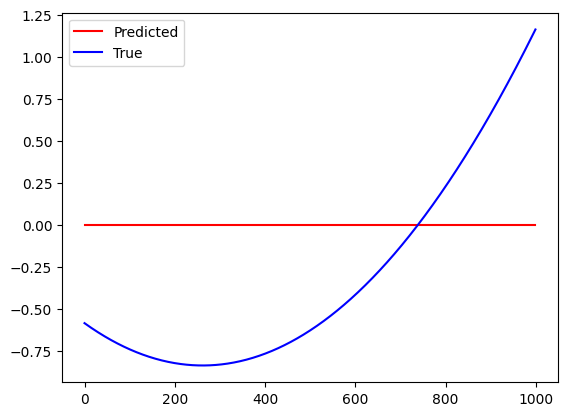

In [24]:
rand = np.random.randint(t_sample_size*num_funcs)
print(best_func[rand])
print(losses[:,rand])
print(best_loss[rand])
plt.plot(best_out[rand].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(t_data.squeeze(1)[rand].detach().cpu().numpy(), "b", label='True')
plt.legend();